# H12 signal detection

In [1]:
# Notebook parameters. Values here are for development only and 
# will be overridden when running via snakemake and papermill.
# cohort_id = 'CD-NU_Gbadolite_gamb_2015_Q3'
cohort_id = 'llineup'
#cohorts_analysis = "20230223"
contig = 'X'
sample_sets = ["1288-VO-UG-DONNELLY-VMF00168","1288-VO-UG-DONNELLY-VMF00219"]
sample_query = "aim_species == 'gambiae' & sex_call == 'F' & admin1_name == 'Western Region'"
min_cohort_size = None
max_cohort_size = None
use_gcs_cache = False
dask_scheduler = "threads"
h12_signal_detection_min_delta_aic = 1000
h12_signal_detection_min_stat_max = 0.1
h12_signal_detection_gflanks = [6]

## Setup

In [11]:
import yaml
import pandas as pd
import malariagen_data
from pyprojroot import here
import numpy as np
import os
import dask
dask.config.set(scheduler=dask_scheduler);
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
import lmfit
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run peak-utils.ipynb

In [12]:
ag3 = malariagen_data.Ag3(pre = True)

In [13]:
# load window sizes from output of h12-calibration
#calibration_dir = "./scripts_notebooks/haplotype_clustering/peak_centre"
calibration_file_path = f"{cohort_id}.yaml"
with open(calibration_file_path, 'r') as calibration_file:
    calibration_params = yaml.safe_load(calibration_file)
window_size = calibration_params["h12_window_size"]
window_size

1000

## Run signal detection

In [14]:
# set parameters for signal detection
filter_size = 20  # hampel filter parameter
filter_t = 2  # hampel filter parameter
scan_interval = 1  # step in cM
min_baseline = 0
max_baseline_percentile = 95
min_amplitude = 0.03
init_amplitude = 0.5
max_amplitude = 1.5
min_decay = 0.1
init_decay = 0.5 
max_abs_skew = 0.5
scan_start = None
scan_stop = None
# TODO maybe set false in production to avoid too many plots?
debug = True

In [15]:
# load gwss data
ppos, h12, x= ag3.h12_gwss(
    contig=contig, 
    window_size=window_size, 
    analysis='gamb_colu', 
    sample_sets=sample_sets,
    sample_query=sample_query, 
    min_cohort_size=min_cohort_size,
    max_cohort_size=max_cohort_size,
)

Load haplotypes:   0%|          | 0/572 [00:00<?, ?it/s]

In [16]:
ppos

array([1.50798800e+03, 4.59604400e+03, 9.36512800e+03, ...,
       2.43195593e+07, 2.43556148e+07, 2.43846031e+07])

In [17]:
# convert to int
ppos = ppos.astype(int)

In [18]:
# map physical to genetic position
gpos = ag_p2g(contig=contig, ppos=ppos)

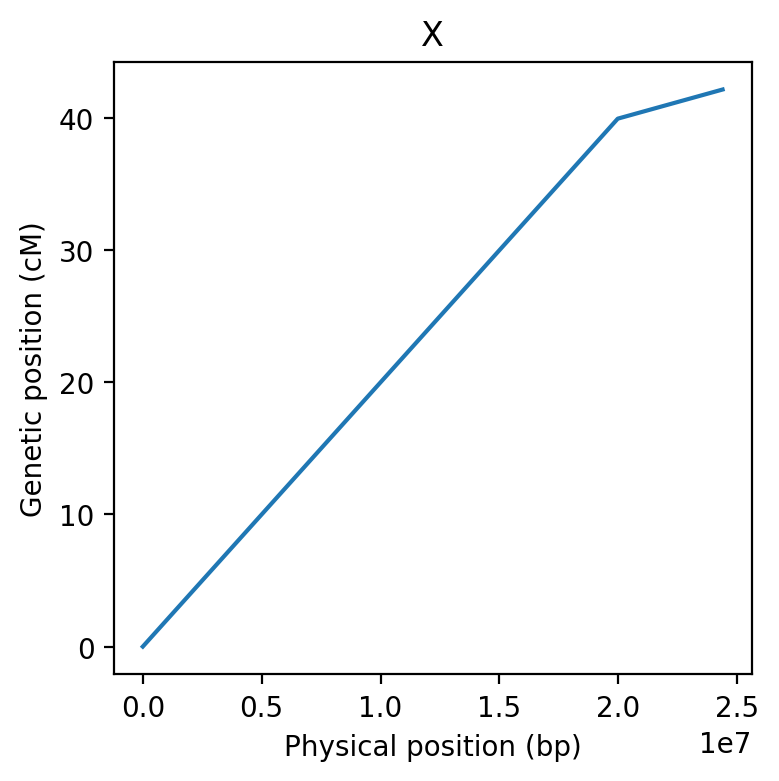

In [19]:
if debug:
    # quick check of genetic map
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(ppos, gpos)
    ax.set_xlabel('Physical position (bp)')
    ax.set_ylabel('Genetic position (cM)')
    ax.set_title(contig)
    fig.tight_layout()


In [20]:
# filter outliers
h12_filtered = hampel_filter(h12, size=filter_size, t=filter_t)

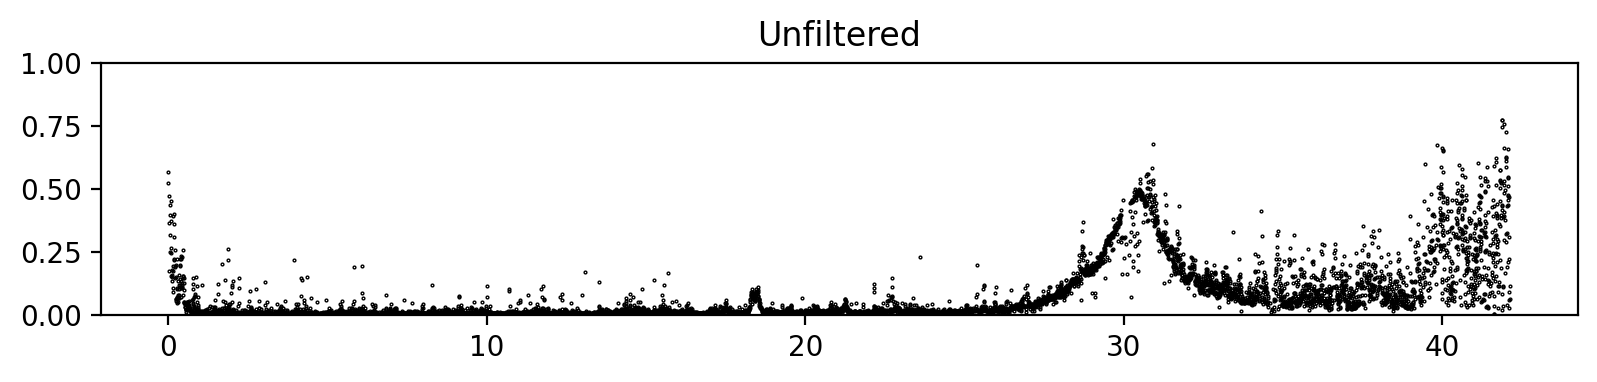

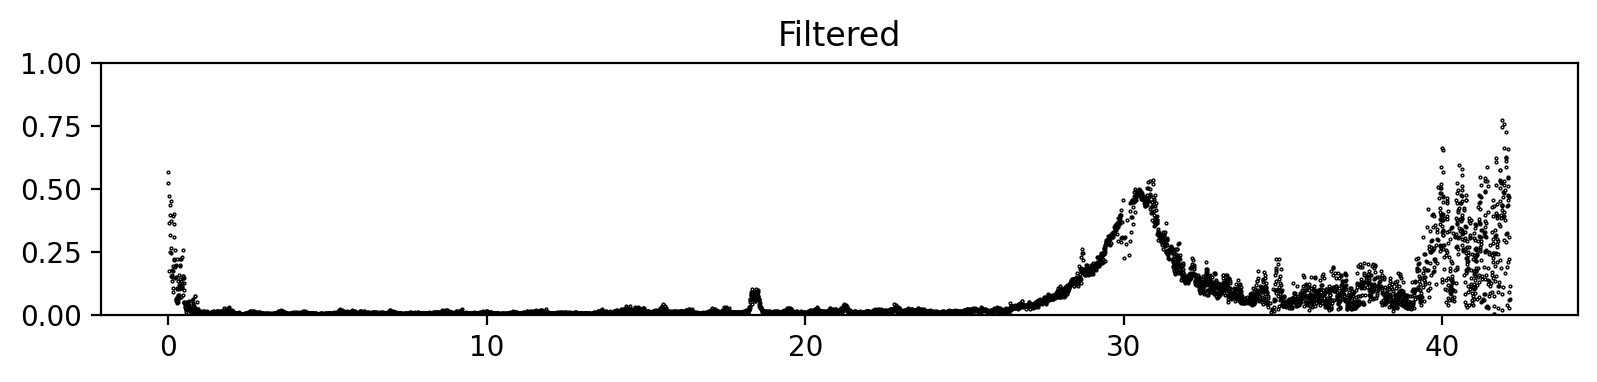

In [21]:
if debug:

    # before filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12, marker='o', linestyle=' ', mfc='none', markersize=1, mew=.5, color='k')
    ax.set_title('Unfiltered')
    ax.set_ylim(0, 1)
    fig.tight_layout()

    # after filtering
    fig, ax = plt.subplots(figsize=(8, 2))
    ax.plot(gpos, h12_filtered, marker='o', linestyle=' ', mfc='none', markersize=1, mew=.5, color='k')
    ax.set_title('Filtered')
    ax.set_ylim(0, 1)
    fig.tight_layout()


In [22]:
# set parameters
init_baseline = np.median(h12_filtered)
max_baseline = np.percentile(h12_filtered, max_baseline_percentile)
min_skew, init_skew, max_skew = -max_abs_skew, 0, max_abs_skew
if not scan_start:
    scan_start = 2
if not scan_stop:
    scan_stop = gpos[-1] - 2

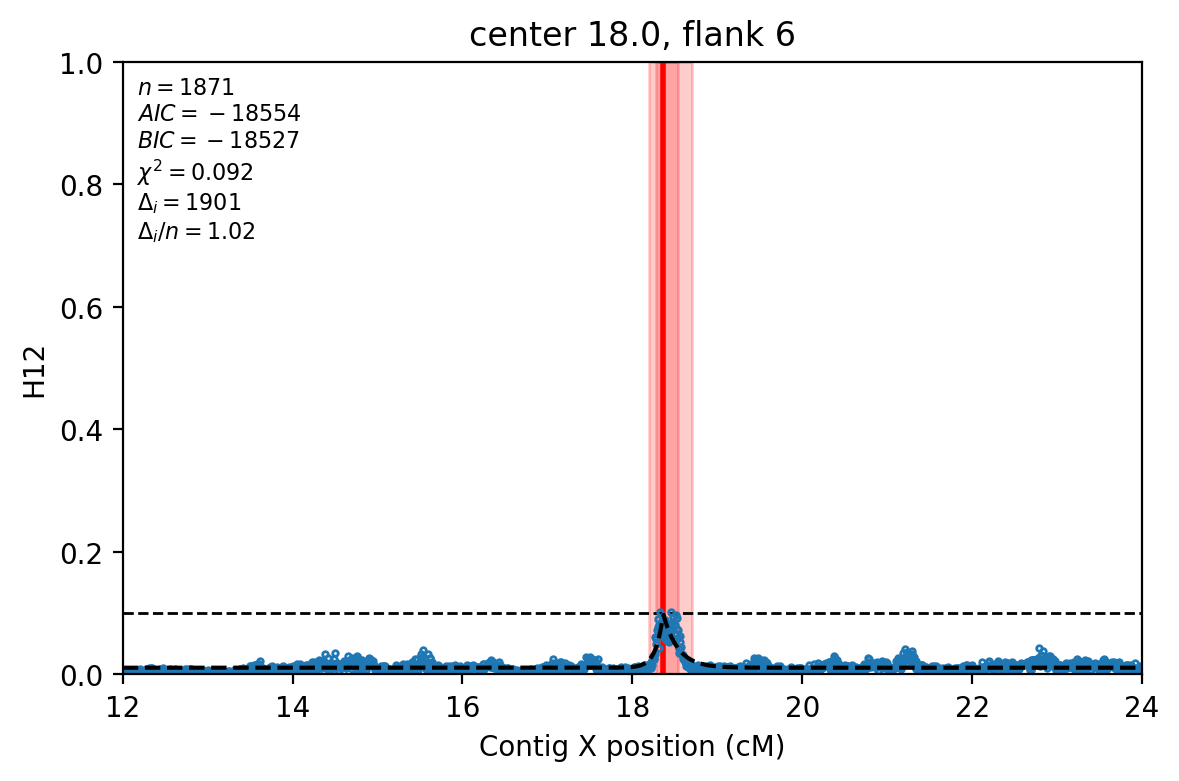

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 1871
    # variables        = 5
    chi-square         = 0.09181683
    reduced chi-square = 4.9205e-05
    Akaike info crit   = -18554.4137
    Bayesian info crit = -18526.7426
    R-squared          = 0.63960614
[[Variables]]
    center:     18.3622970 +/- 0.00278214 (0.02%) (init = 18)
    amplitude:  0.08814823 +/- 0.00208852 (2.37%) (init = 0.5)
    decay:      0.12116245 +/- 0.00448556 (3.70%) (init = 0.5)
    skew:      -0.50000000 +/- 0.01322423 (2.64%) (init = 0)
    baseline:   0.01096367 +/- 1.6976e-04 (1.55%) (init = 0.01467308)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = -0.6847
    C(amplitude, decay) = -0.6348
    C(decay, skew)      = -0.2534
    C(decay, baseline)  = -0.2060
    C(center, decay)    = +0.1533


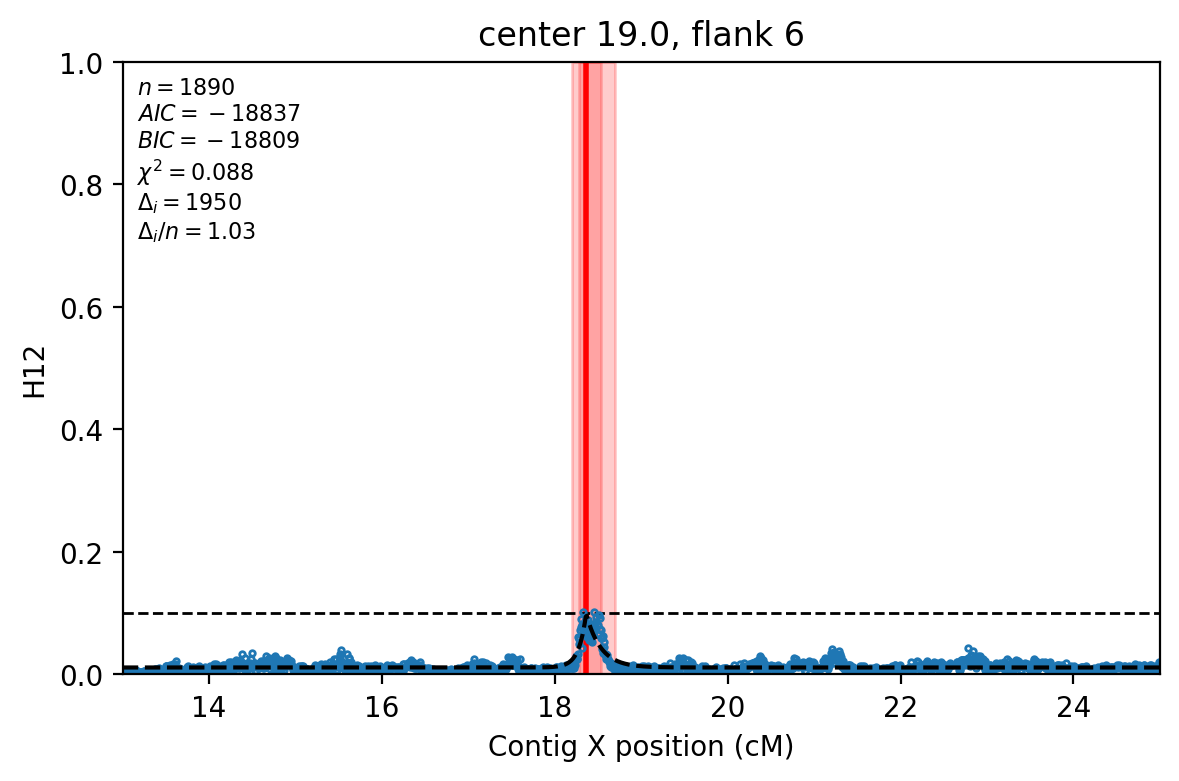

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 93
    # data points      = 1890
    # variables        = 5
    chi-square         = 0.08824599
    reduced chi-square = 4.6815e-05
    Akaike info crit   = -18837.0027
    Bayesian info crit = -18809.2810
    R-squared          = 0.64506850
[[Variables]]
    center:     18.3622739 +/- 0.00270532 (0.01%) (init = 19)
    amplitude:  0.08786722 +/- 0.00204865 (2.33%) (init = 0.5)
    decay:      0.11981507 +/- 0.00436400 (3.64%) (init = 0.5)
    skew:      -0.50000000 +/- 0.01802660 (3.61%) (init = 0)
    baseline:   0.01134857 +/- 1.6459e-04 (1.45%) (init = 0.01467308)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(center, skew)     = -0.6847
    C(amplitude, decay) = -0.6351
    C(decay, skew)      = -0.2529
    C(decay, baseline)  = -0.2037
    C(center, decay)    = +0.1522


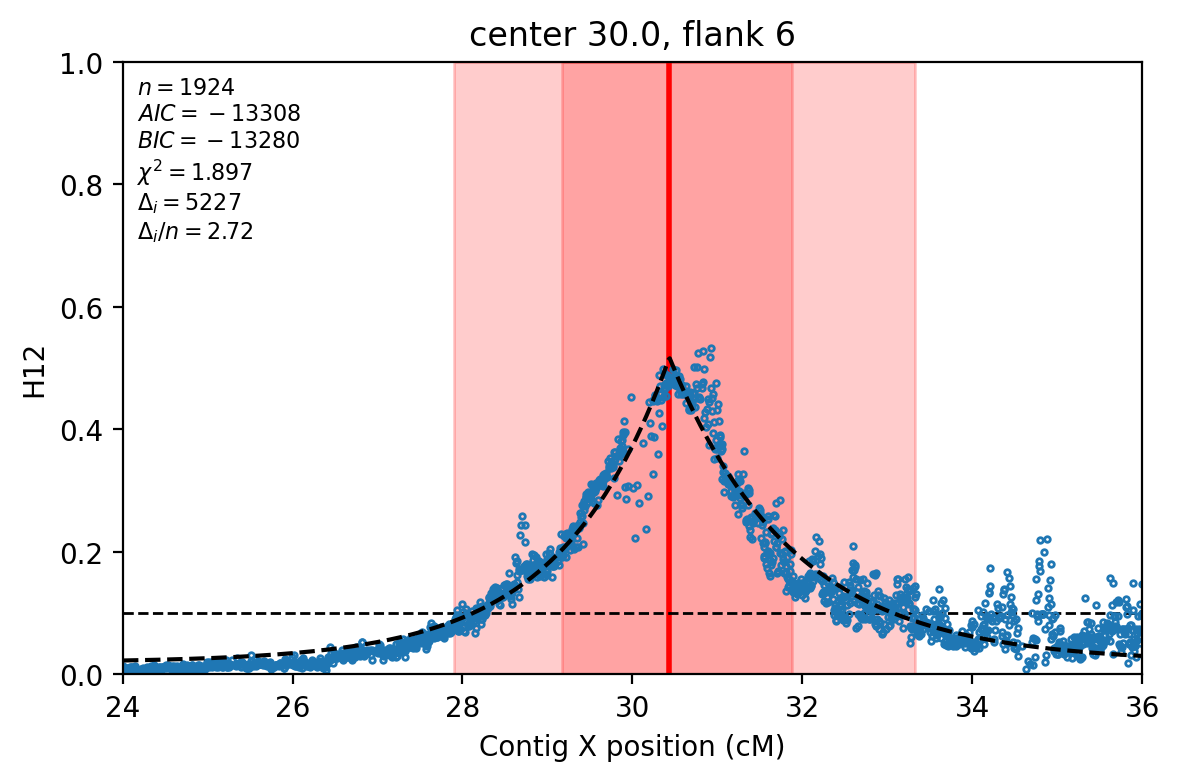

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 1924
    # variables        = 5
    chi-square         = 1.89667884
    reduced chi-square = 9.8837e-04
    Akaike info crit   = -13308.0382
    Bayesian info crit = -13280.2274
    R-squared          = 0.93419694
[[Variables]]
    center:     30.4354959 +/- 0.00905734 (0.03%) (init = 30)
    amplitude:  0.49775475 +/- 0.00329829 (0.66%) (init = 0.5)
    decay:      1.35490368 +/- 0.01920438 (1.42%) (init = 0.5)
    skew:      -0.09366050 +/- 0.01260371 (13.46%) (init = 0)
    baseline:   0.01962650 +/- 0.00157225 (8.01%) (init = 0.01467308)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)   = -0.7892
    C(center, skew)      = +0.7275
    C(amplitude, decay)  = -0.3883
    C(center, amplitude) = -0.1358
    C(decay, skew)       = +0.1286
    C(center, decay)

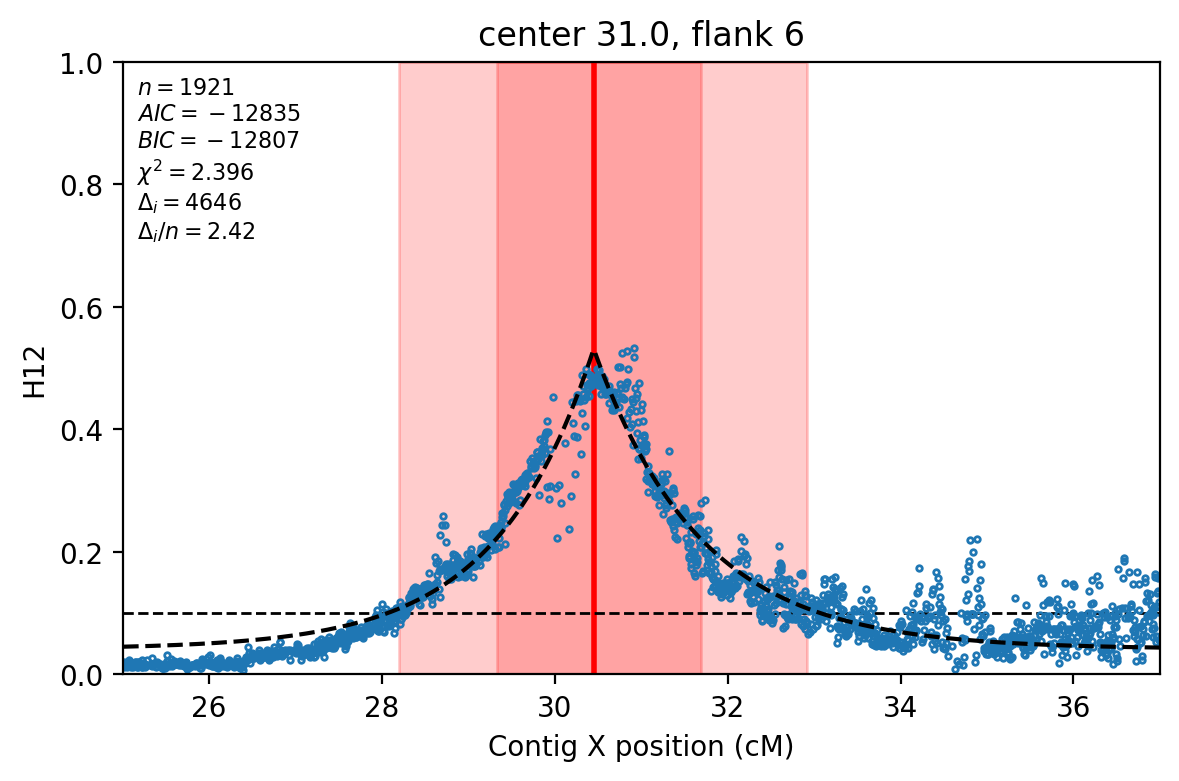

[[Model]]
    Model(skewed_exponential_peak)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 1921
    # variables        = 5
    chi-square         = 2.39614272
    reduced chi-square = 0.00125060
    Akaike info crit   = -12835.2293
    Bayesian info crit = -12807.4263
    R-squared          = 0.91133291
[[Variables]]
    center:     30.4494293 +/- 0.00959353 (0.03%) (init = 31)
    amplitude:  0.49007925 +/- 0.00395977 (0.81%) (init = 0.5)
    decay:      1.17860647 +/- 0.01868498 (1.59%) (init = 0.5)
    skew:      -0.06835759 +/- 0.01518420 (22.21%) (init = 0)
    baseline:   0.04140144 +/- 0.00156537 (3.78%) (init = 0.01467308)
    ceiling:    1 (fixed)
    floor:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(decay, baseline)   = -0.7478
    C(center, skew)      = +0.7185
    C(amplitude, decay)  = -0.4523
    C(center, amplitude) = -0.1637


,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
0,llineup,X,18.362297,9181149,1901,0.102659,18.456456,9228228,18.358013,18.370864,...,0.088148,0.121162,-0.500000,0.085675,0.171350,0.010964,-18554.413693,-18526.742552,0.091817,-16652.950063
1,llineup,X,18.362274,9181137,1949,0.102659,18.456456,9228228,18.358038,18.370746,...,0.087867,0.119815,-0.500000,0.084722,0.169444,0.011349,-18837.002652,-18809.280992,0.088246,-16887.283069
2,llineup,X,30.435496,15217748,5227,0.532865,30.921062,15460531,30.372009,30.507785,...,0.497755,1.354904,-0.093660,1.269737,1.445783,0.019627,-13308.038158,-13280.227350,1.896679,-8080.662974
3,llineup,X,30.449429,15224715,4646,0.532865,30.921062,15460531,30.393226,30.511219,...,0.490079,1.178606,-0.068358,1.124064,1.235795,0.041401,-12835.229301,-12807.426295,2.396143,-8188.902677


In [23]:
# set up results
results = []

# main loop, iterate along the genome
for gcenter in np.arange(scan_start, scan_stop, scan_interval):

    for gflank in h12_signal_detection_gflanks:

        # print('center', gcenter, 'flank size', gflank)

        result = fit_exponential_peak(
            ppos=ppos, 
            gpos=gpos, 
            stat_filtered=h12_filtered, 
            gcenter=gcenter, 
            gflank=gflank, 
            scan_interval=scan_interval,
            init_amplitude=init_amplitude,
            min_amplitude=min_amplitude,
            max_amplitude=max_amplitude,
            init_decay=init_decay,
            min_decay=min_decay,
            init_skew=init_skew,
            min_skew=min_skew,
            max_skew=max_skew,
            init_baseline=init_baseline,
            min_baseline=min_baseline,
            max_baseline=max_baseline,
            min_delta_aic=h12_signal_detection_min_delta_aic,
            min_stat_max=h12_signal_detection_min_stat_max,
            debug=debug,
        )

        if result is not None:
            results.append(result)

df_signals = pd.DataFrame.from_records(results)
df_signals

In [23]:
def dedup_signals(df_signals):
    
    keep = list(range(len(df_signals)))
    for i, this in df_signals.iterrows():
        for j, that in df_signals.iterrows():
            if i != j:
                # thank you Ned Batchelder
                # https://nedbatchelder.com/blog/201310/range_overlap_in_two_compares.html
                disjoint = that.span1_gstart > this.span1_gstop or that.span1_gstop < this.span1_gstart
                if not disjoint and that.delta_i > this.delta_i:
                    keep.remove(i)
                    break
    return df_signals.iloc[keep].copy()


In [24]:
df_signals_dedup = dedup_signals(df_signals)
df_signals_dedup

,cohort_id,contig,gcenter,pcenter,delta_i,stat_max,gpos_max,ppos_max,focus_gstart,focus_gstop,...,amplitude,decay,skew,decay_left,decay_right,baseline,aic,bic,rss,constant_aic
1,llineup,X,18.362274,9181137,1949,0.102659,18.456456,9228228,18.358038,18.370746,...,0.087867,0.119815,-0.50000,0.084722,0.169444,0.011349,-18837.002652,-18809.280992,0.088246,-16887.283069
2,llineup,X,30.435496,15217748,5227,0.532865,30.921062,15460531,30.372009,30.507785,...,0.497755,1.354904,-0.09366,1.269737,1.445783,0.019627,-13308.038158,-13280.227350,1.896679,-8080.662974


## Write outputs

In [ ]:
outdir= "./scripts_notebooks/haplotype_clustering/peak_centre"
os.makedirs(outdir, exist_ok=True)
with open(os.path.join(outdir, f"{cohort_id}_{contig}.csv"), mode="w") as output_file:
    df_signals_dedup.to_csv(output_file, index=False)